<a href="https://colab.research.google.com/github/Ritwik-1/OCR-on-bus-images/blob/master/OCR_BusImages_Ritwik.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pytesseract
!pip install Pillow
!sudo apt-get install tesseract-ocr
!sudo apt-get install libtesseract-dev
!sudo apt-get install tesseract-ocr-hin
!sudo apt-get install tesseract-ocr
!sudo apt-get install libtesseract-dev
!sudo apt-get install tesseract-ocr-hin

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 24 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 2s (2,028 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debc

In [ ]:
import os
import pandas as pd
import numpy as np
import cv2
import requests
from PIL import Image
from io import BytesIO
import pytesseract
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
pytesseract.pytesseract.tesseract_cmd = '/usr/bin/tesseract'

In [ ]:
def info_image(img_arr):
    print(img_arr.shape)
    print(img_arr.dtype)
    print(type(img_arr))
    print(np.max(img_arr))
    print(np.min(img_arr))

# using pytesseract
def extract_text_from_image(image_path):
    # img = Image.open(image_path)
    # print(type(img))
    # custom_config = r'--oem 3 --psm 6'
    custom_config = r'--psm 6'

    extracted_text = pytesseract.image_to_string(image_path, config=custom_config)
    return extracted_text

def plot_images(img1, img2, title1="", title2=""):
    fig = plt.figure(figsize=[15,15])
    ax1 = fig.add_subplot(121)
    ax1.imshow(img1, cmap="gray")
    ax1.set(xticks=[], yticks=[], title=title1)

    ax2 = fig.add_subplot(122)
    ax2.imshow(img2, cmap="gray")
    ax2.set(xticks=[], yticks=[], title=title2)

In [ ]:
image_url = 'https://i0.wp.com/www.opindia.com/wp-content/uploads/2021/07/delhibus-750x450-1.jpg?fit=750%2C450&ssl=1'

# image_url = "https://images.indianexpress.com/2022/12/dehli-bus-1200.jpg"
response = requests.get(image_url)
img = Image.open(BytesIO(response.content))

img.show()
img.save('bus.jpg')

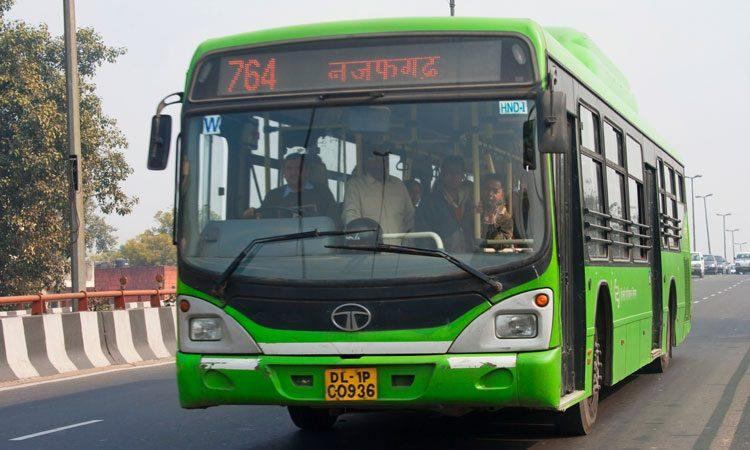

In [ ]:
image_bgr = cv2.imread("bus.jpg")
cv2_imshow(image_bgr)

In [ ]:
info_image(image_bgr)

(450, 750, 3)
uint8
<class 'numpy.ndarray'>
255
0


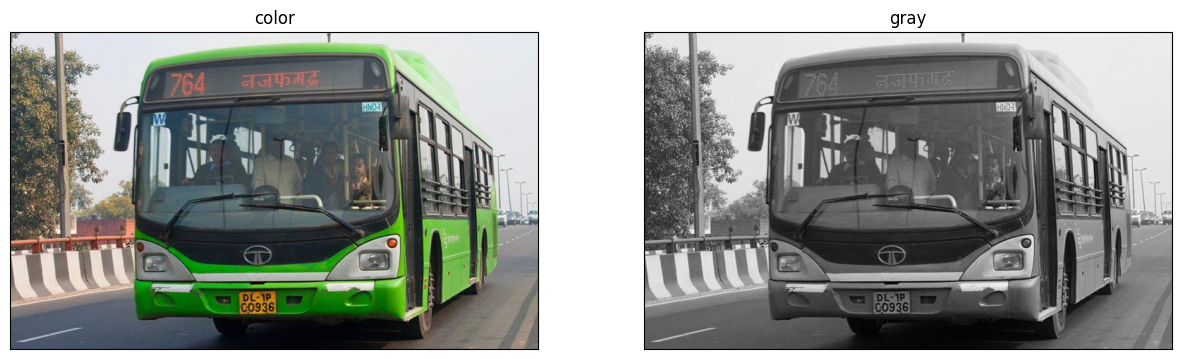

In [ ]:
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(image_rgb, cv2.COLOR_BGR2GRAY)
plot_images(image_rgb,gray,"color","gray")

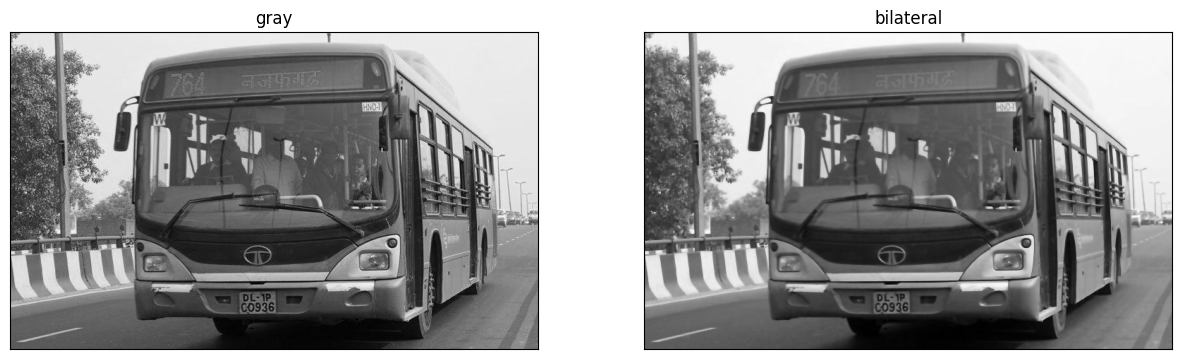

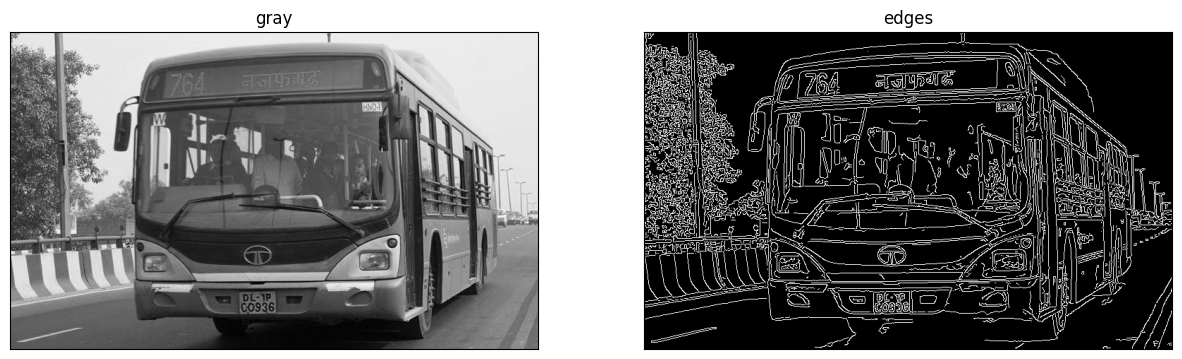

In [ ]:
bilateral_filtered_image = cv2.bilateralFilter(gray, d=4, sigmaColor=45, sigmaSpace=55)
edges = cv2.Canny(bilateral_filtered_image, threshold1=18, threshold2=52)

plot_images(gray,bilateral_filtered_image,"gray","bilateral")
plot_images(gray,edges,"gray","edges")

In [ ]:
cnts, new = cv2.findContours(edges.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
cnts = sorted(cnts, key=cv2.contourArea, reverse=True)[:800]
image_copy = image_rgb.copy()
# parameters : -1 draw all contours , (255,0,255) : magenta colour , 2 : line thickness
_ = cv2.drawContours(image_copy, cnts, -1, (255,0,255),1)

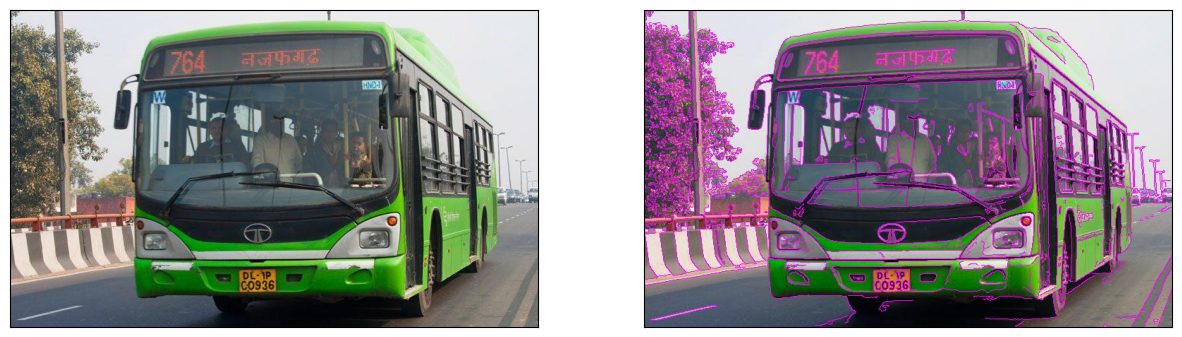

In [ ]:
plot_images(image_rgb, image_copy)

In [ ]:
print(type(cnts))
print(len(cnts))

<class 'list'>
800


#### IDENTIFYING THE DIGITAL PANEL

Hello :  (68, 328)


True

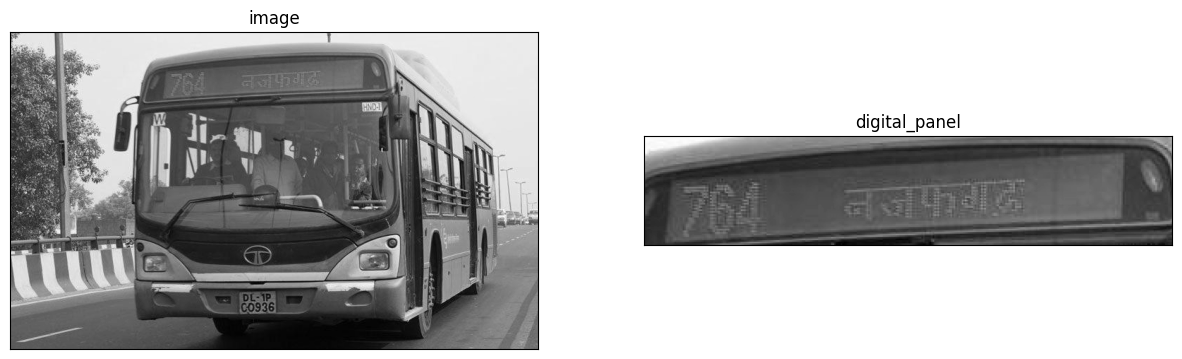

In [ ]:
image_copy_2 = gray.copy()

digital_panel = None

m_x,m_y,m_w,m_h = 0,0,0,0
max_width = 0

for c in cnts:
    x,y,w,h = cv2.boundingRect(c)
    aspect_ratio = w/float(h)
    # if  3.875 <= aspect_ratio <= 3.5:
    if(w > 310 and w < 350 and h > 80 and h < 100):
        # cv2.rectangle(image_copy_2, (x, y), (x + w, y + h), (0, 255, 0), 2)
        digital_panel = image_copy_2[y:y+h-15, x:x+w-15]
        print("Hello : ",digital_panel.shape)
        break

# _, binary_image = cv2.threshold(digital_panel,113, 1, cv2.THRESH_BINARY)

# binary_image = binary_image.astype(np.uint8)

# binary_image_bgr = cv2.cvtColor(binary_image, cv2.COLOR_GRAY2BGR)

plot_images(image_copy_2,digital_panel,"image","digital_panel")
cv2.imwrite("digital_panel.png",digital_panel)
# max_width = 355
#

#### IDENTIFYING THE NUMBER PLATE

<class 'numpy.ndarray'>


True

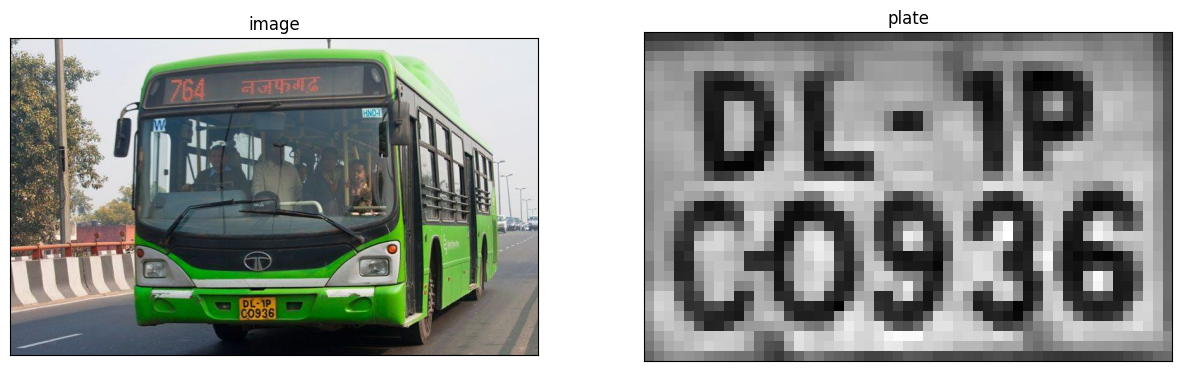

In [ ]:
plate = None

for c in cnts:
  perimeter = cv2.arcLength(c, True)
  edges_count = cv2.approxPolyDP(c, 0.1*perimeter, True)
  if len(edges_count) == 4:
    x,y,w,h = cv2.boundingRect(c)
    plate = gray[y:y+h, x:x+w]
    break

print(type(plate))
plate = cv2.bilateralFilter(plate, d=1, sigmaColor=30, sigmaSpace=35)
plot_images(image_rgb,plate,"image","plate")
cv2.imwrite("plate.png",plate)

#### EXTRACTING TEXT

---



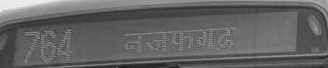


<class 'str'>


In [ ]:
panel = extract_text_from_image("digital_panel.png")

pan = cv2.imread("digital_panel.png")
cv2_imshow(pan)

print(panel)
print(type(panel))

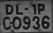

DLP
C0936

<class 'str'>


In [ ]:
number_plate = extract_text_from_image("plate.png")

num_pl = cv2.imread("plate.png")
cv2_imshow(num_pl)

print(number_plate)
print(type(number_plate))

In [ ]:
# image_url = 'https://media.geeksforgeeks.org/wp-content/uploads/20201218171110/sampletext.png'

# response = requests.get(image_url)
# test_img = Image.open(BytesIO(response.content))

# test_img.show()
# test_img.save('test_OCR_image.png')

# testing = extract_text_from_image("test_OCR_image.png")

# print(testing)
# print(type(testing))

now children state should after above same long made such
point run take call together few being would walk give

<class 'str'>


In [ ]:
# image_url = 'https://media.geeksforgeeks.org/wp-content/uploads/20201222143437/d.JPG'

# response = requests.get(image_url)
# test_img_2 = Image.open(BytesIO(response.content))

# test_img_2.show()
# test_img_2.save('test_OCR_image_2.png')

# testing_2 = extract_text_from_image("test_OCR_image_2.png")

# print(testing_2)
# print(type(testing_2))

GeeksforGeeks

<class 'str'>
